# Hypothesis Testing
### Understanding Uncertainty

## Introduction
- Statistics is a great field, but we aren't statisticians
- These tools are very useful for thinking about first-order (predictive) uncertainty and second-order (model reliability) uncertainty
- And, if you go around saying "I'm a data scientist", people will assume you know this material

## The Sampling Distribution
- We want to return to the concept of a **sampling distribution**
- If you repeat an experiment over and over, then plot the KDE or ECDF, you are estimating something ($\mathbb{E}[ \hat{F}_n(x) ] = F(x)$)
- What are you estimating?
- It is essentially an estimate of the reliability of your statistical procedure: Given your measurement and analytics techniques, do you get a stable, coherent answer?
- This is the sampling distribution, and becomes the foundation of all statistical procedures

## Roadmap
1. Bootstrap Inference
2. Standard Errors
3. Classical Hypothesis Testing

## Bootstrapping
- We have bootstrapped throughout class, but recall: To bootstrap the sampling distribution of a statistic $\hat{\theta}$, we

    1. Pick a large number, $B$, like 2500 or 5000 or 10000
    2. Resample the data, with replacement, $B$ times
    3. For each resample of the data, compute your statistic, $\hat{\theta}_b$
    4. The ECDF is an estimate of the sampling distribution of $\hat{\theta}$ 

Notice, this ECDF is not an estimate of the distribution of $\theta$, because $\theta$ is a number and not a random variable. This distribution is an estimate of statistical reliability, not $pr[\Theta = \theta | \text{ data }]$

## Random Sampling and Representativeness
- We should pause and point out: We're assuming that your sample is representative of the original population
- If your sample has **sampling bias** and over-samples some subset of the population or the instruments you use for measurements have **measurement bias** and collect incorrect data, then your sample will differ systematically from the properties of the original population
- Arguably, if your sample is too small for your modes of analysis, then you have sampling bias as well
- Bootstrapping can't really fix this: Garbage in, garbage out

## Hedonic Pricing, Again
- We'll look at the prices of housing in Ames, IA
- The goal is to do a non-trivial example of extracting the sampling distribution of a statistic
- We'll get the sampling distributions of the regression coefficients

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/ames_prices.csv')
print(df.head())

df['age'] = df['Yr.Sold']-df['Year.Built']

# Numeric variables:
numeric_vars = ['price', 'area', 'age' ]
X_num = df.loc[:,numeric_vars]

# Create dummy variables/fixed effects/one hot encode:
ac = pd.get_dummies(df['Central.Air'],drop_first=True, dtype=int)
fireplaces = pd.get_dummies(df['Fireplaces'],drop_first=True, dtype=int)
style = pd.get_dummies(df['House.Style'], dtype=int)

data = pd.concat([X_num, ac, style],axis=1)
data = data.dropna()


   Order        PID  area   price  MS.SubClass MS.Zoning  Lot.Frontage  \
0      1  526301100  1656  215000           20        RL         141.0   
1      2  526350040   896  105000           20        RH          80.0   
2      3  526351010  1329  172000           20        RL          81.0   
3      4  526353030  2110  244000           20        RL          93.0   
4      5  527105010  1629  189900           60        RL          74.0   

   Lot.Area Street Alley  ... Screen.Porch Pool.Area Pool.QC  Fence  \
0     31770   Pave   NaN  ...            0         0     NaN    NaN   
1     11622   Pave   NaN  ...          120         0     NaN  MnPrv   
2     14267   Pave   NaN  ...            0         0     NaN    NaN   
3     11160   Pave   NaN  ...            0         0     NaN    NaN   
4     13830   Pave   NaN  ...            0         0     NaN  MnPrv   

  Misc.Feature Misc.Val Mo.Sold Yr.Sold Sale.Type Sale.Condition  
0          NaN        0       5    2010       WD          Nor

In [2]:
y = data['price']
X = data.drop('price',axis=1)
vars = X.columns
print(vars)

# OLS function
def OLS(X, y):
    try:
        # Try exact OLS
        beta = np.linalg.solve(X.T @ X, X.T @ y)
    except np.linalg.LinAlgError:
        # If singular, regularize
        print('Whoops! Singular. L2/Ridge stabilizing...')
        lam = 1e-10
        beta = np.linalg.solve(X.T @ X + lam * np.eye(X.shape[1]), X.T @ y)
    error = y - X @ beta
    sigma = np.sqrt( np.sum( error ** 2 )/ len(y) )
    return beta, sigma

beta_hat, sigma_hat = OLS(X,y)

# Bootstrap the sampling distribution of coefficients
def boot(data):
    data_s = data.sample(frac=1,replace=True)
    y_s = data_s['price']
    X_s = data_s.drop('price',axis=1)
    beta_hat_s = OLS(X_s,y_s)
    return beta_hat_s

n_boot = 5_000
replications = [ boot(data) for s in range(n_boot) ]


Index(['area', 'age', 'Y', '1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf',
       '2Story', 'SFoyer', 'SLvl'],
      dtype='object')
Whoops! Singular. L2/Ridge stabilizing...
Whoops! Singular. L2/Ridge stabilizing...


['area',
 'age',
 'Y',
 '1.5Fin',
 '1.5Unf',
 '1Story',
 '2.5Fin',
 '2.5Unf',
 '2Story',
 'SFoyer',
 'SLvl']

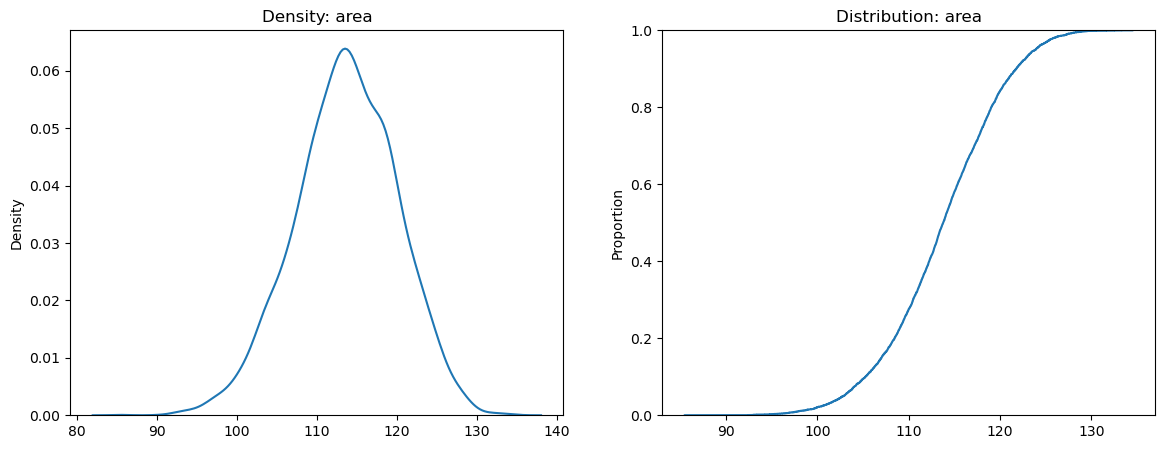

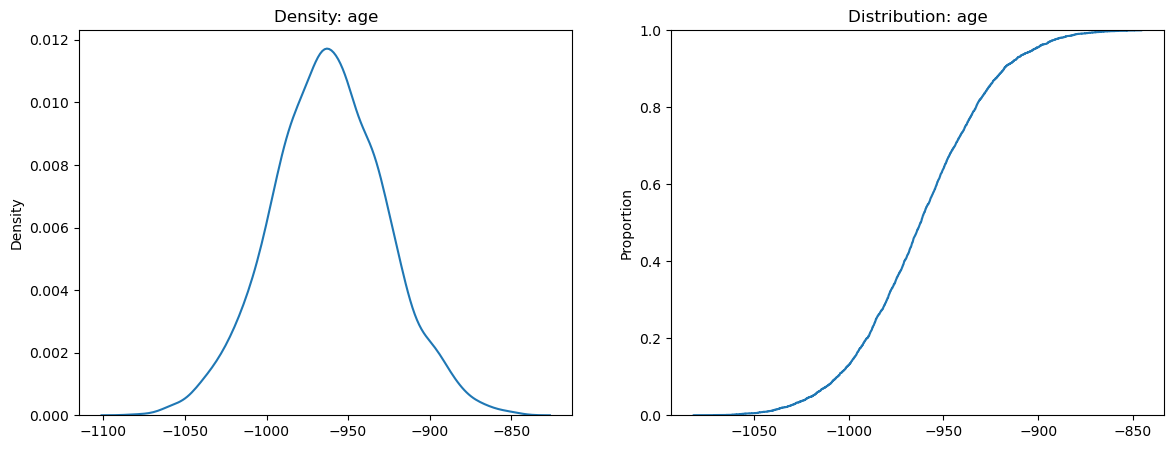

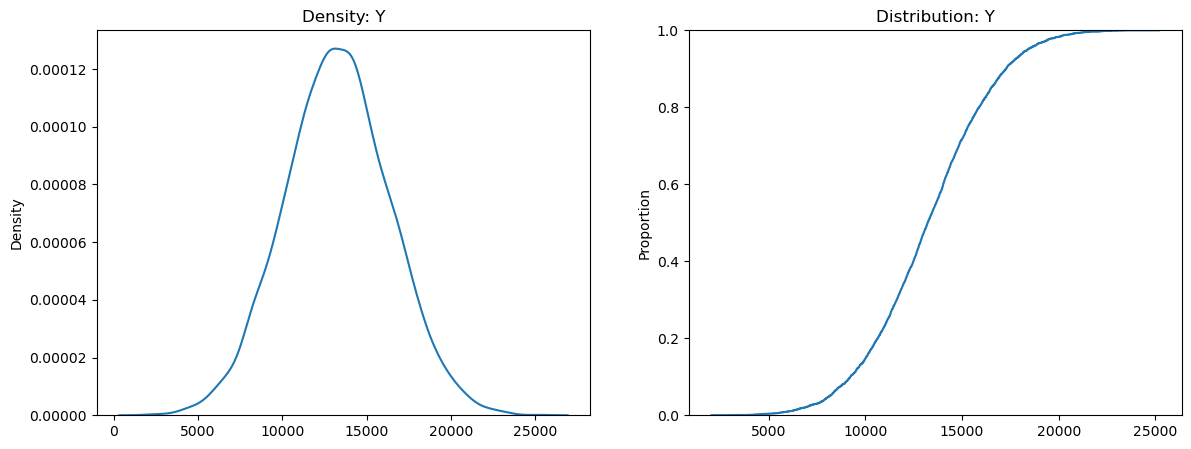

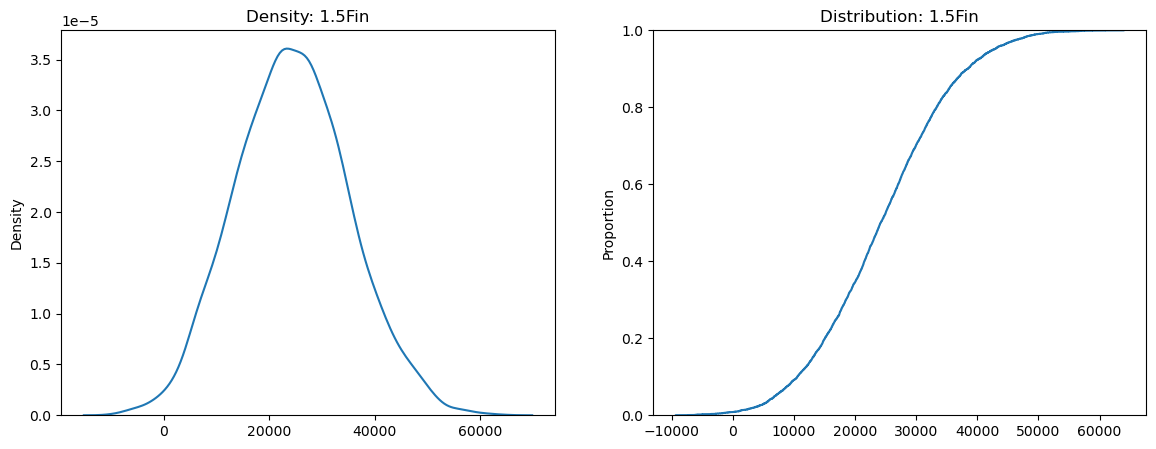

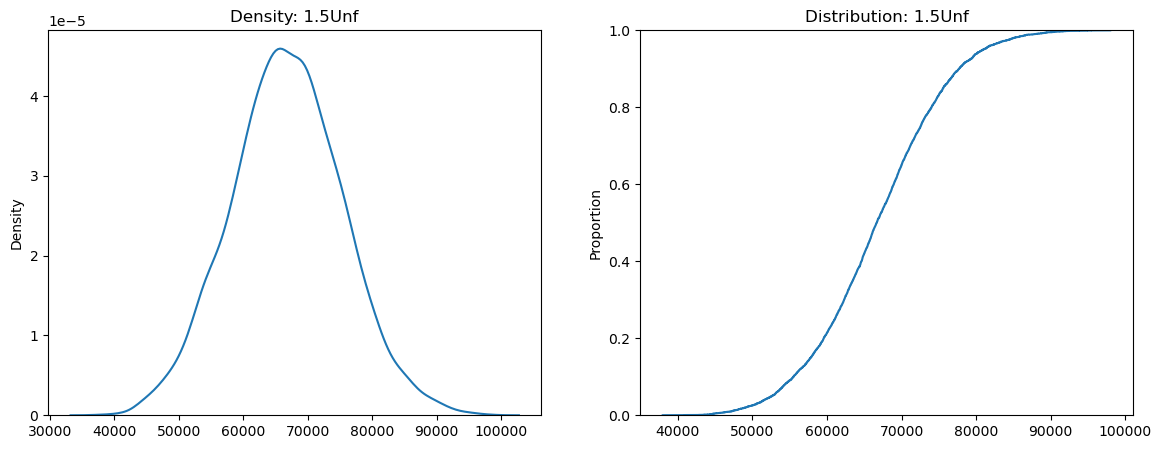

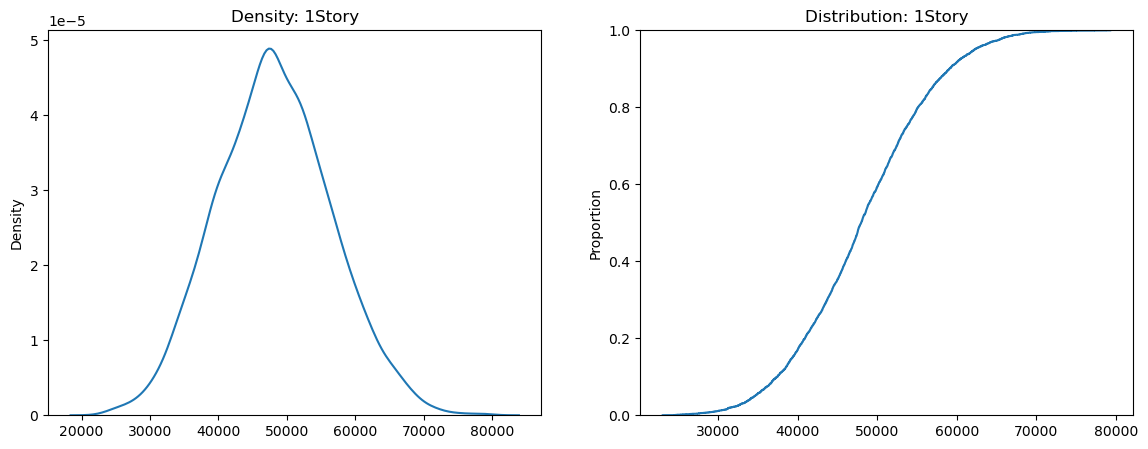

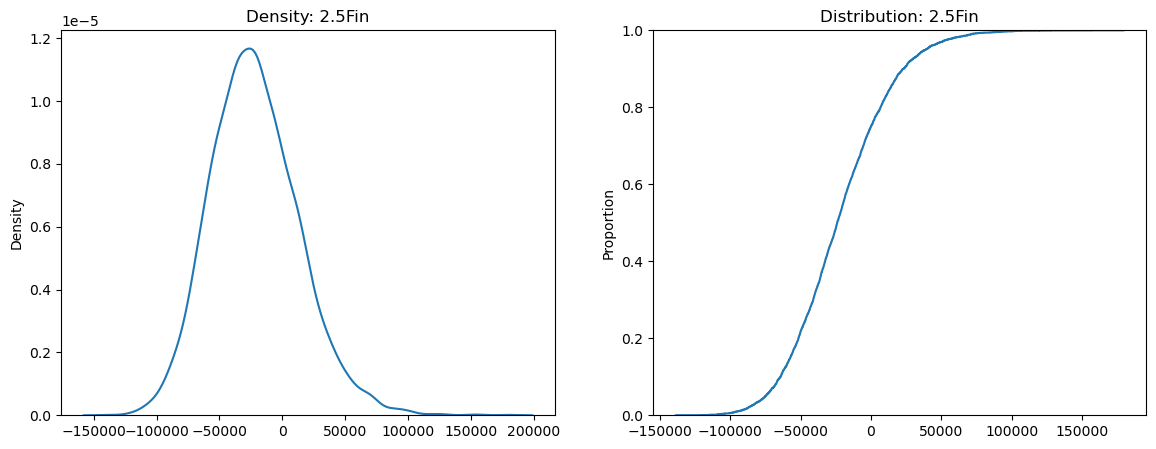

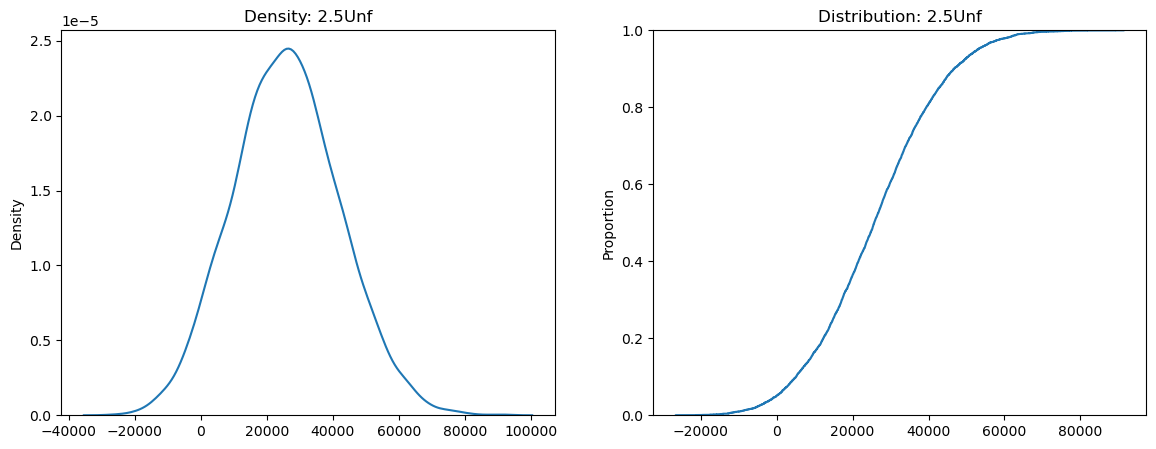

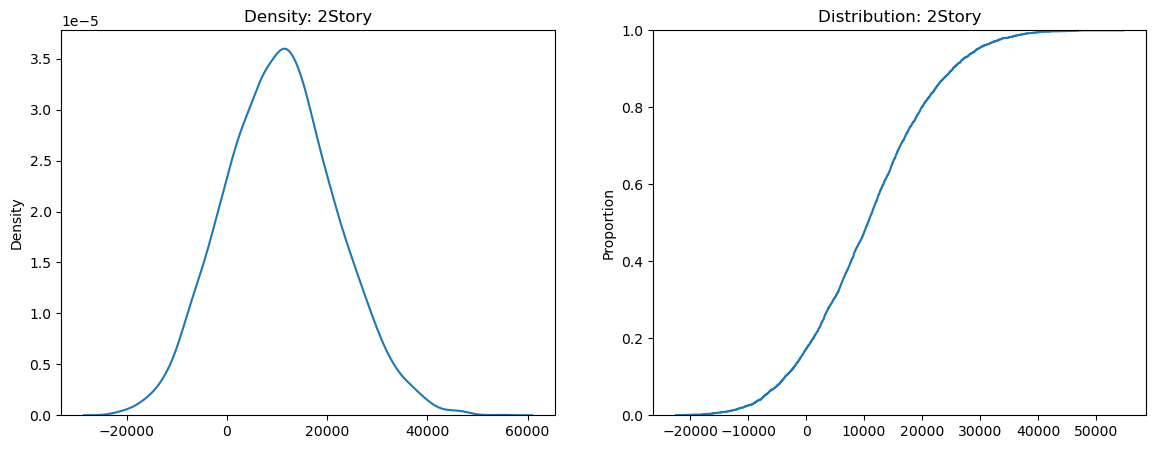

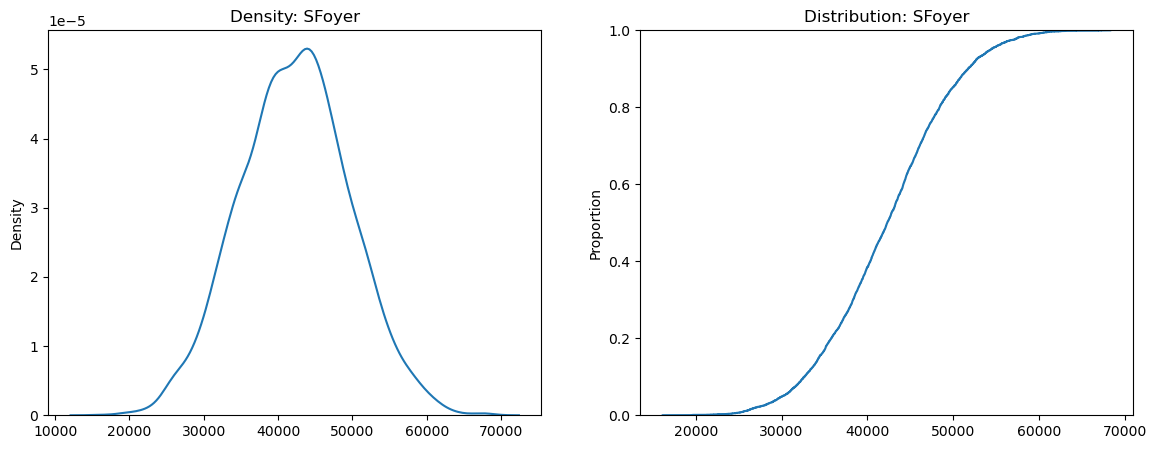

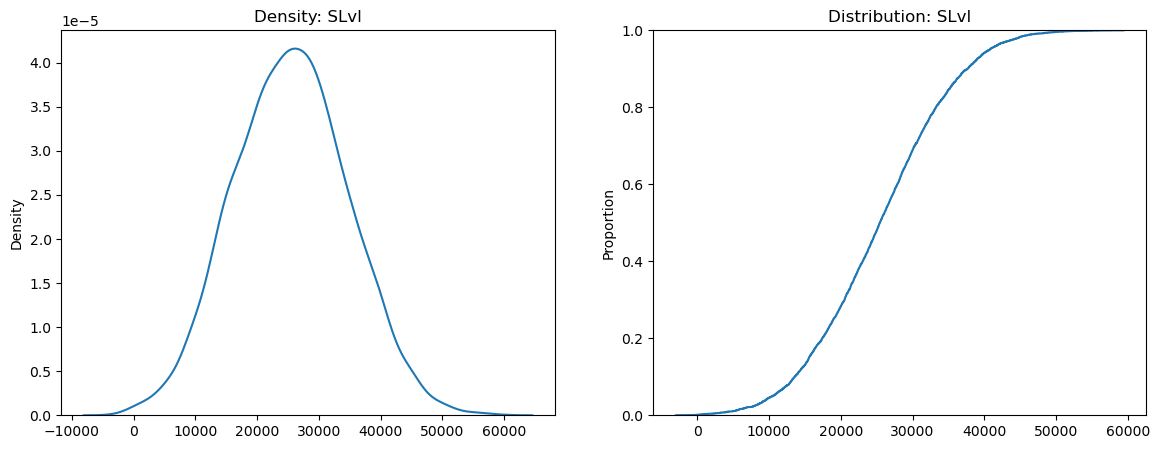

In [3]:
# Extract coefficients for each bootstrap replication and plot:
def inference_plots(i, replications):
    these_coefs = [ row[0][i] for row in replications]
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    sns.kdeplot(these_coefs,ax=axes[0])
    axes[0].set_title(f'Density: {vars[i]}')
    sns.ecdfplot(these_coefs,ax=axes[1])
    axes[1].set_title(f'Distribution: {vars[i]}')
    return vars[i]

# Plot sampling distributions for all the coefficients
[ inference_plots(i, replications) for i in range(len(vars)) ]

- Notice how these plots all look the same?

## Communicating Results
- How do we communicate our results? These plots can be difficult to interpret and understand.
- A **90/95/99% (percentile bootstrap) confidence interval** reports the (.05, .95)/(.025, .975)/(.005, .995) quantiles of the bootstrapped sampling distribution.
- This bounds some proportion of bootstrap results in an interval, giving a more concrete answer to what values the coefficient is likely to take.

Confidence interval for area: (105.24954872007666, 121.76654628362837)
Confidence interval for age: (-1005.9878533310501, -918.016471670479)
Confidence interval for Y: (9229.149401473283, 17277.29158037356)
Confidence interval for 1.5Fin: (10570.535688700218, 38423.69465015883)
Confidence interval for 1.5Unf: (55505.94826935326, 77709.65837457441)
Confidence interval for 1Story: (37401.62753540433, 59069.66066755369)
Confidence interval for 2.5Fin: (-64293.47106385056, 23035.38532768167)
Confidence interval for 2.5Unf: (5126.304189332855, 46751.649267280794)
Confidence interval for 2Story: (-3654.0880498554498, 25292.149493094665)
Confidence interval for SFoyer: (32640.016961235266, 51737.76690344273)
Confidence interval for SLvl: (13582.60050353813, 37693.250536516534)


['area',
 'age',
 'Y',
 '1.5Fin',
 '1.5Unf',
 '1Story',
 '2.5Fin',
 '2.5Unf',
 '2Story',
 'SFoyer',
 'SLvl']

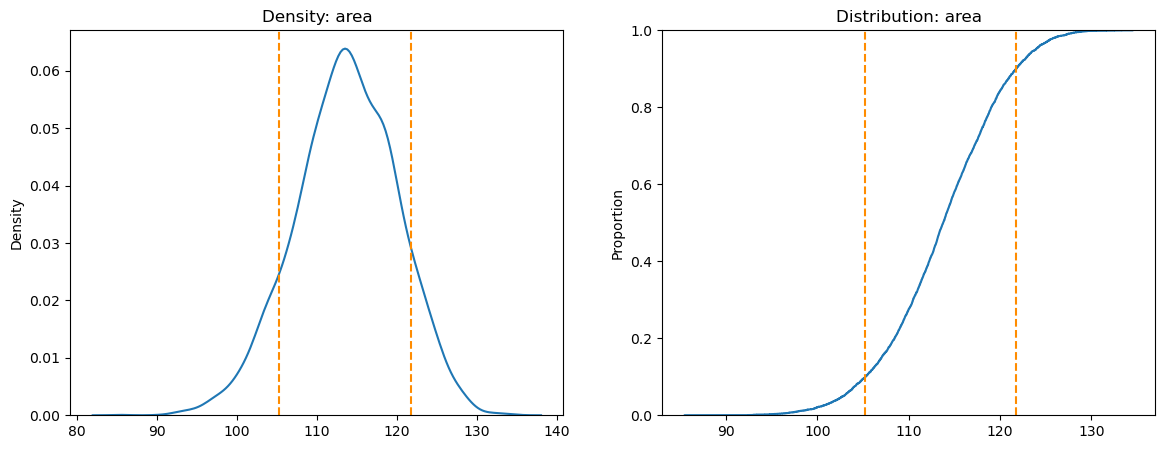

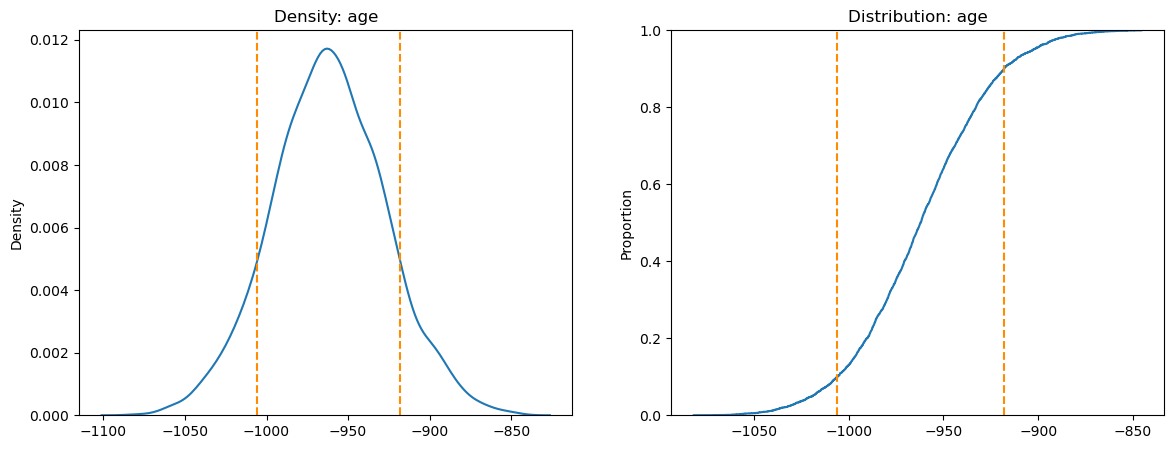

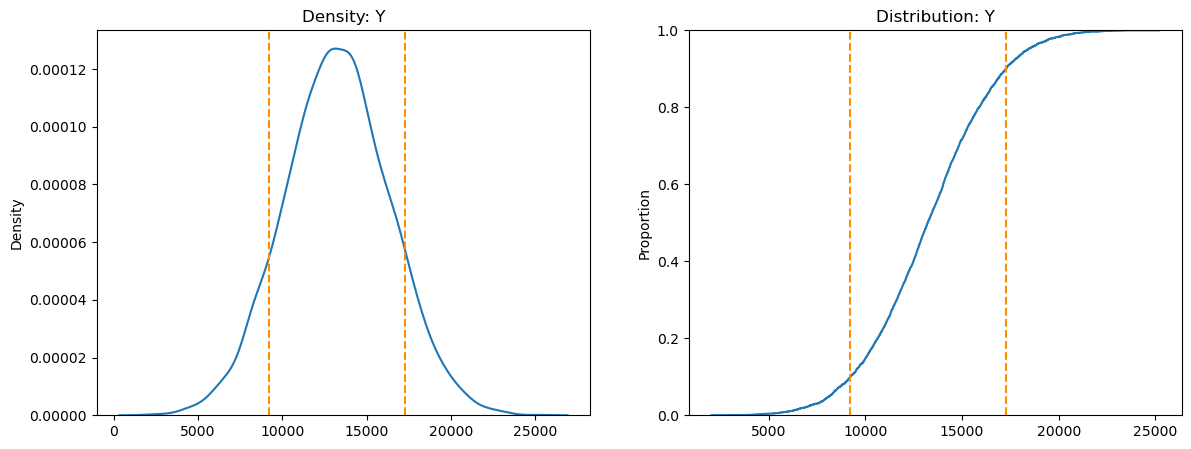

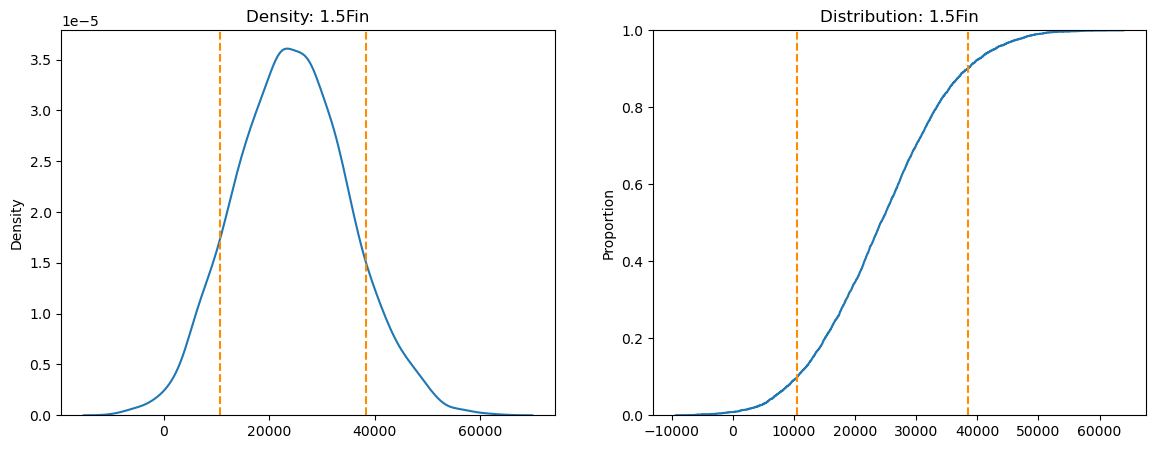

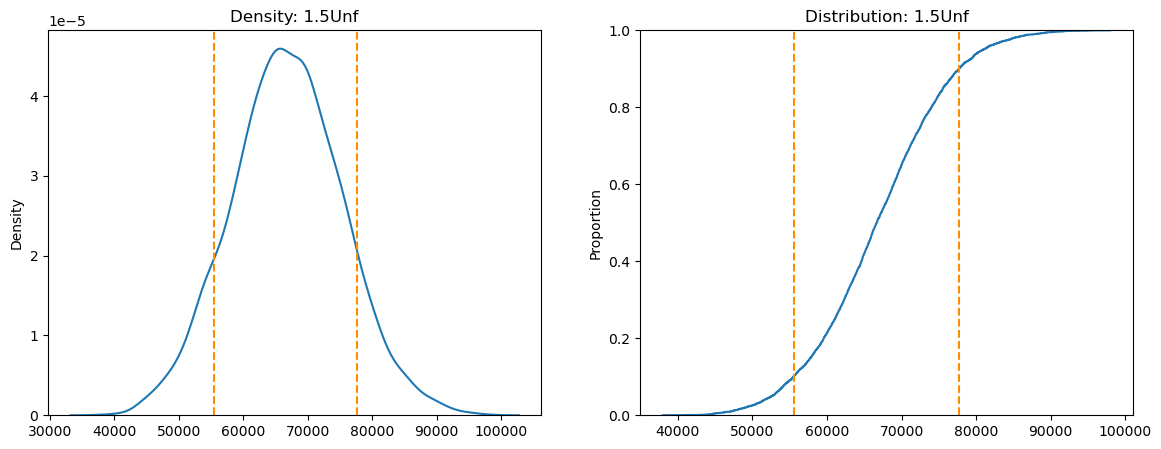

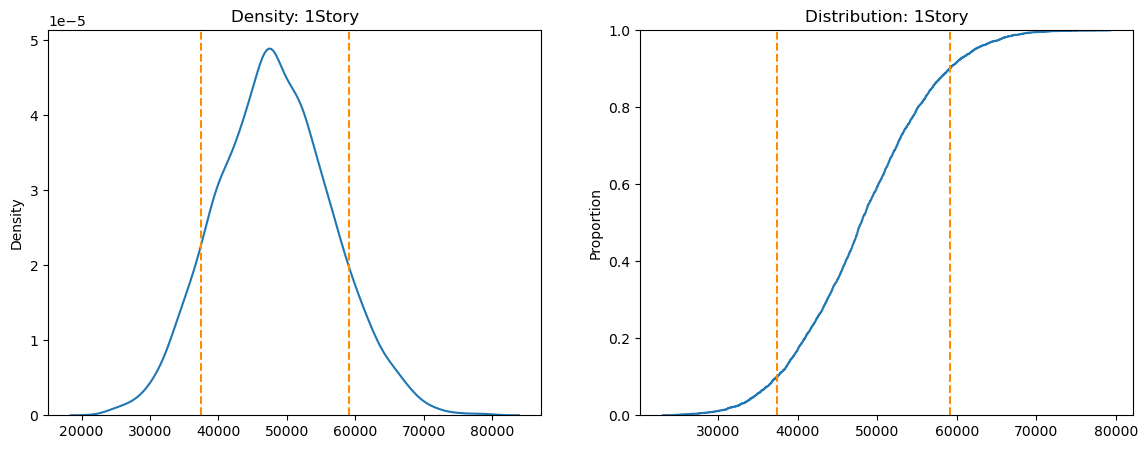

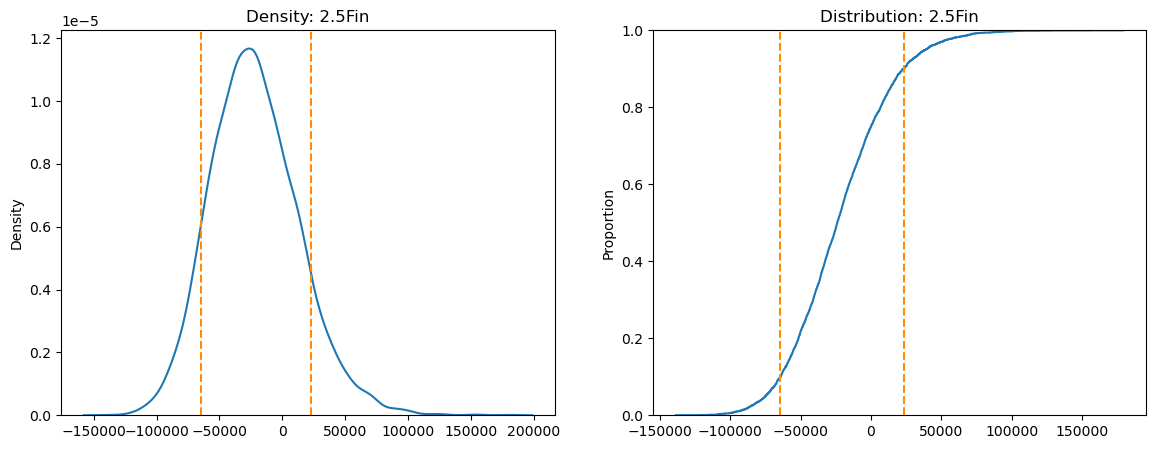

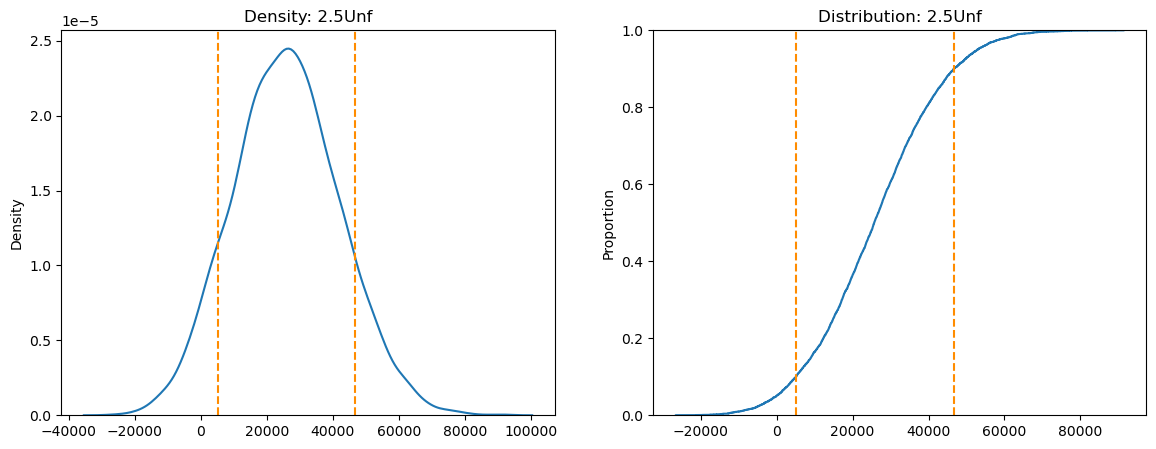

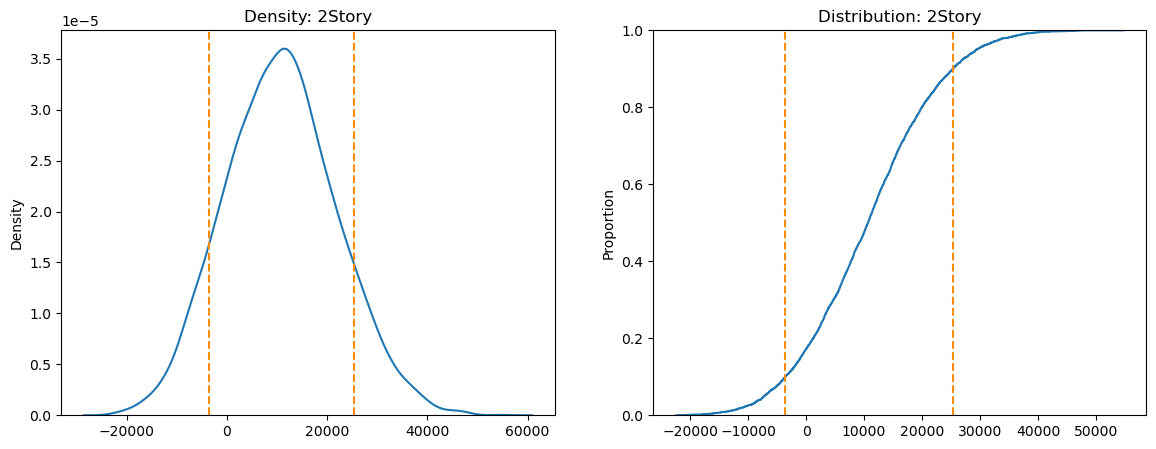

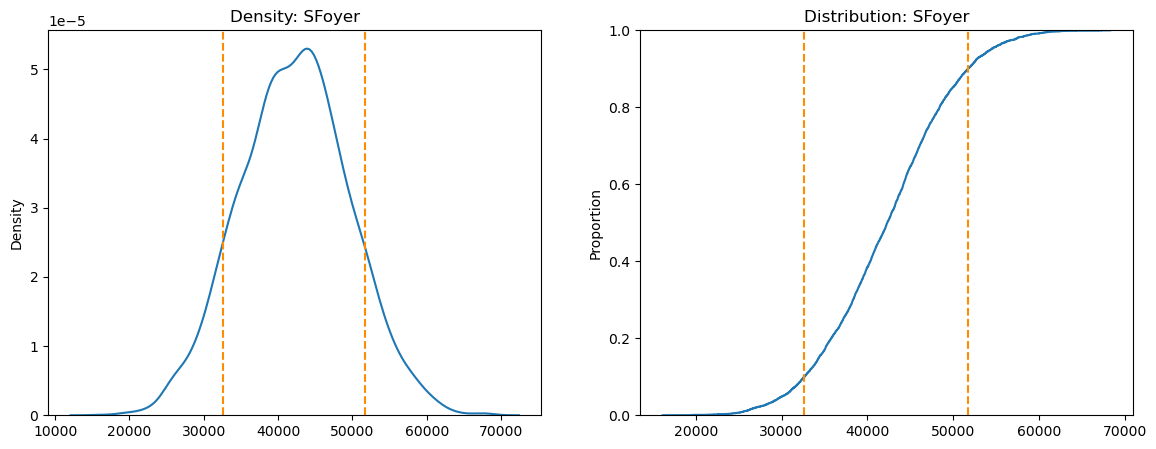

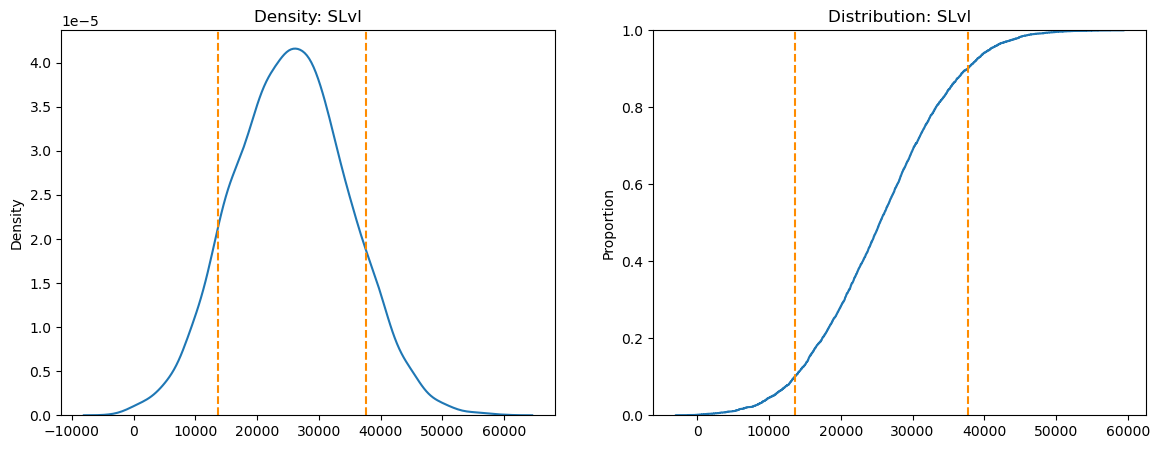

In [4]:
# Extract coefficients for each bootstrap replication and plot:
def inference_plots(i, replications, alpha = None):
    these_coefs = [ row[0][i] for row in replications]
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    sns.kdeplot(these_coefs,ax=axes[0])
    axes[0].set_title(f'Density: {vars[i]}')
    sns.ecdfplot(these_coefs,ax=axes[1])
    axes[1].set_title(f'Distribution: {vars[i]}')

    if alpha is not None:
        L = np.quantile(these_coefs, alpha)
        H = np.quantile(these_coefs, 1- alpha)
        axes[0].axvline(L, color='darkorange', linestyle='--')
        axes[0].axvline(H, color='darkorange', linestyle='--')
        axes[1].axvline(L, color='darkorange', linestyle='--')
        axes[1].axvline(H, color='darkorange', linestyle='--')
        print(f'Confidence interval for {vars[i]}: ({L}, {H})')
    return vars[i]

# Plot sampling distributions for all the coefficients
[ inference_plots(i, replications, alpha=.1) for i in range(len(vars)) ]

## Hypothesis Testing
- In science, you cannot prove a hypothesis, only refute them (e.g. Karl Popper)
- So we set up scenarios in which **we want to reject the "null" hypothesis**, and then consult the evidence
- The most common null hypothesis is that the true $\mu_0 = 0$, and the confidence interval contains zero
- For your particular application, it might be something else (e.g. $\mu_0=1$ might have special significance, or $\mu_0\gtrless 0$)
- To run a hypothesis test, we ask, "Are the data consistent with the null? If not, we reject it in favor of the alternative hypothesis."
- So the null $\mu_0$ is something we pick before we even get started on our test, assume it is true, and then attempt to show it is inconsistent with the data (e.g. pre-registering a randomized controlled trial)
- This is a data-drive reductio ad absurdum

## From CI to Hypothesis
- The **confidence interval** is the $(\alpha,1-\alpha)$-quantile interval of bootstrap replications ($\alpha = .1/.05/.01$)
- We call $\alpha$ the **level** of the test and it corresponds to a $100 \times (1-\alpha)$% **confidence interval** (90%, 95%, 99%)
- These are typically **two-tailed tests**, so that $\alpha/2$ probability is included in each of the tails of the density of the sampling distribution

Confidence interval for age: (-1005.9878533310501, -918.016471670479)


'age'

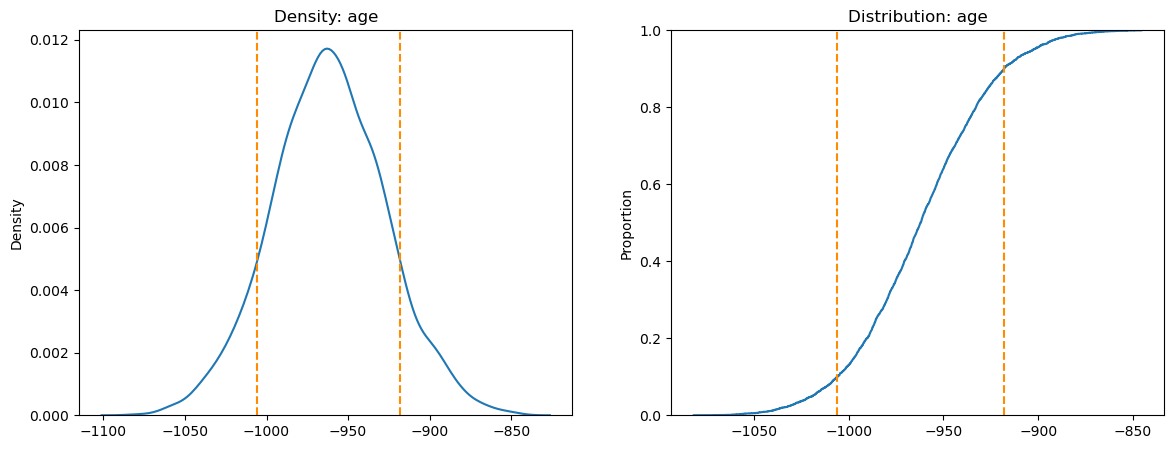

In [5]:
inference_plots(1, replications, alpha=.1) 

## Hypothesis Testing
- So let's take Age. We would say, "I am testing whether the Age coefficient is statistically significantly different from 0 at the 0.1 level (=90% confidence)." We consult our 90%-CI for Age above: (-1007.186, -916.865). This does not contain zero. "We reject the null hypothesis that the Age coefficient is zero at the 0.1 level." 
- Alternatively, take 2Story. We would say, "I am testing whether the 2Story coefficient is statistically significantly different from 0 at the 0.1 level (=90% confidence)." We consult our 90%-CI for 2Story above: (-3577.244, 26156.690). This does contain zero. "We fail to reject the null hypothesis that the 2Story coefficient is zero at the 0.1 level." 


In [6]:
import statsmodels.api as sm
reg = sm.OLS(y, X).fit() # Linear regression object
print(reg.summary()) # Summary table

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     663.0
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:08:53   Log-Likelihood:                -35496.
No. Observations:                2930   AIC:                         7.101e+04
Df Residuals:                    2919   BIC:                         7.108e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
area         113.3221      2.009     56.399      0.0

In [7]:
# StatsModels 90% CI:
reg.conf_int(alpha=0.10)

,0,1
area,110.016093,116.628188
age,-1017.726500,-905.344832
Y,7543.730356,19216.479079
1.5Fin,14482.056190,35005.399988
1.5Unf,48411.636139,85321.179628
1Story,40409.650536,56466.459696
2.5Fin,-51024.819687,7222.339405
2.5Unf,8174.639460,44621.773350
2Story,2020.849736,20426.879097
SFoyer,31477.074137,53318.631277


In [8]:
print(f'Our estimates: \n {beta_hat}')

Our estimates: 
 [   113.32214058   -961.53566606  13380.10471738  24743.72808928
  66866.40788346  48438.0551161  -21901.240141    26398.20640494
  11223.86441639  42397.85270689  25754.10952431]


- Confidence interval for area: (104.83493620433785, 121.64294371966409)
- Confidence interval for age: (-1007.1864500981183, -916.8650771166855)
- Confidence interval for Y: (9265.108957167713, 17225.465631231335)
- Confidence interval for 1.5Fin: (10664.28182641897, 39206.110393330186)
- Confidence interval for 1.5Unf: (55540.733396558535, 78323.87952968468)
- Confidence interval for 1Story: (37312.33759990846, 59620.07865121928)
- Confidence interval for 2.5Fin: (-65818.35283455071, 23071.12668757549)
- Confidence interval for 2.5Unf: (5125.07670310073, 47626.40286165537)
- Confidence interval for 2Story: (-3577.2439268139187, 26156.69036874485)
- Confidence interval for SFoyer: (32609.71126375071, 52321.592675465145)
- Confidence interval for SLvl: (13564.4860367852, 38360.41539747156)

- Percentile Bootstrapped CIs *tend* to be wider (but not always) than the ones reported from statistical packages, which use asymptotic formulas rather than data-driven methods
- There are many versions of Bootstrapped CIs, which tend to be smaller and closer to the asymptotic forumulas: If your bootstrapped sampling distribution looks skewed, it can impact performance, and a more complex version of the bootstrap CI might work better

## $p$-Values
- The $p$-value is an attempt to avoid picking the level of the test
- So the confidence interval is the $(\alpha,1-\alpha)$ interval of bootstrap replications, and we call $\alpha$ the **level** of the test
- Instead, if we adjusted $\alpha$ to be as small as possible without including 0, how small could we make it?
- This quantity is called a $p$-value: "What is the minimum level I can get away with and still reject the null?"

# IID Sequences and Standard Errors

## Independent and Identically Distributed Sequences (iid)
- A fundamental concept in probability and statistics is the abstract idea of running an "experiment" over and over, and computing statistics for the results
- Let $x_1$ be the result of the first experiment, $x_2$ the result of the second, and so on
- Assume that the draws $x_1, x_2, ...$ 
  - are **identically distributed**: They are all drawn from the same distribution function and all have the same mean $\mu$ and variance $\sigma^2$
  - are **independent**: The outcome of draw $x_n$ doesn't affect the outcome of any draw $x_m$, $m \neq n$
- The **sample average** of our experimental sequence is
$$
\bar{X}_n = \dfrac{1}{n} \sum_{i=1}^n x_i
$$
and the **sample variance** of our experimental sequence is
$$
\bar{s}_n^2 = \dfrac{1}{n} \sum_{i=1}^n (x_i - \bar{X}_n)^2
$$

## Independent and Identically Distributed Sequences (iid)
- The sample average and sample variance are now, themselves, random variables, with their own outcomes, events, probabilities, and so on
- What is the expected value of $\bar{X}_n$?
$$
\mathbb{E}[\bar{X}_n] = \mathbb{E}\left[ \dfrac{1}{n} \left( X_1 + X_2 + ... + X_n \right) \right] = \dfrac{\mathbb{E}[X_1] + ... + \mathbb{E}[X_n]}{n} = 
\dfrac{\mu + ... + \mu}{n} = \dfrac{n\mu}{n} = \mu
$$


## Standard Error of the Mean
- Likewise, but with slightly different steps:
\begin{alignat*}{2}
\mathbb{V}[\bar{X}_n] &=& \mathbb{V}\left[\frac{1}{n}(X_1 + X_2 + ... + X_n)\right] \\
&=& \frac{1}{n^2} \mathbb{V}[X_1 + X_2 + ... + X_n] \quad \text{(HW 6)}\\
&=& \frac{1}{n^2} \left( \mathbb{V}[X_1] + \mathbb{V}[X_2] + ... + \mathbb{V}[X_n] \right) \quad \text{(Independence)}\\
&=& \frac{n}{n^2} \sigma^2 \\
&=& \frac{\sigma^2}{n} 
\end{alignat*}
- The standard deviation of the sample mean is written as
$$
SE[\bar{X}_n] = \dfrac{\sigma}{\sqrt{n}}
$$
In hypothesis testing, you will see this $1/\sqrt{n}$ term appear everywhere: It is what drives the variance of our estimates to zero as our sample size gets large; this is part of why we want "big data"
- This kind of quantity, $\sigma/\sqrt{n}$, is so ubiquitous it gets a name: **STANDARD ERROR**

## Standard Errors

# THE STANDARD ERROR IS 
# THE STANDARD DEVIATION 
# OF THE SAMPLING DISTRIBUTION

- For more complex statistical models like regressions, the standard errors are more complex
- For linear regression, the standard errors are the square roots of the diagonal elements of $\hat{\sigma}^2 (X^{\top}X)^{-1}$
- For general maximum likelihood estimation, we can compute standard errors from the shape of the log-likelihood function
- We can compute a standard error for any quantity using bootstrapping. We compute the standard deviation of our bootstrap replication values:
$$
SE[\hat{\theta}] = \sqrt{\frac{1}{B-1} \sum_{b=1}^B (\hat{\theta}_b - \bar{\hat{\theta}})^2}
$$
where $\bar{\hat{\theta}} = \frac{1}{B}\sum_{b=1}^B \hat{\theta}_{b}$

In [9]:
print(reg.summary()) # Summary table

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     663.0
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:08:53   Log-Likelihood:                -35496.
No. Observations:                2930   AIC:                         7.101e+04
Df Residuals:                    2919   BIC:                         7.108e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
area         113.3221      2.009     56.399      0.0

In [10]:
## Bootstrapped Standard Errors:

def boot_se(vars, replications):
    se = []
    for i in range(len(vars)):
        these_coefs = [ row[0][i] for row in replications]
        theta_hat_bar = np.mean(these_coefs)
        err = these_coefs - theta_hat_bar
        se_theta = np.sqrt(np.sum(err ** 2)/(len(these_coefs)-1))
        se.append(se_theta)
    return se

se_boot = boot_se(vars,replications)
pd.DataFrame({'variable':vars,'standard_error':se_boot})

,variable,standard_error
0,area,6.360054
1,age,34.870615
2,Y,3121.059018
3,1.5Fin,10765.215700
4,1.5Unf,8639.146969
5,1Story,8376.038218
6,2.5Fin,35141.088144
7,2.5Unf,16131.491889
8,2Story,11111.476660
9,SFoyer,7376.945425


In [11]:
se_ols = np.sqrt( np.diag( np.linalg.inv( X.T@X ) ) ) *  sigma_hat  # Analytic SEs
pd.DataFrame({'variable':vars, 'bootstrap_SE': se_boot, 'analytic_SE':se_ols})

,variable,bootstrap_SE,analytic_SE
0,area,6.360054,2.005521
1,age,34.870615,34.086594
2,Y,3121.059018,3540.472862
3,1.5Fin,10765.215700,6224.955534
4,1.5Unf,8639.146969,11195.069832
5,1Story,8376.038218,4870.206533
6,2.5Fin,35141.088144,17667.002946
7,2.5Unf,16131.491889,11054.815923
8,2Story,11111.476660,5582.750816
9,SFoyer,7376.945425,6624.784116


- But you can bootstrap SEs for anything you can estimate